In [1]:
import sys
sys.path.append("../../../libraries/pvae/")
from pvae.manifolds.poincareball import PoincareBall
from pvae.manifolds.euclidean import Euclidean
from pvae.models.architectures import EncWrapped, DecWrapped
from pvae.distributions.wrapped_normal import WrappedNormal
from pvae.distributions.riemannian_normal import RiemannianNormal
from pvae.ops.manifold_layers import GeodesicLayer
from pvae.objectives import vae_objective
from torch.distributions.normal import Normal
sys.path.append("../../../libraries/")
from HypHC.optim.radam import RAdam
sys.path.append("../../hyperLAI/")
import math
import torch
from torch import nn
import networkx as nx
from models.hyperbolic_hc_loss import HyperbolicHCLoss
from torch.utils.data import SubsetRandomSampler, DataLoader, Subset
from torch.optim import Adam
from utils.sim_funcs import sim_func_dict
from utils.model_utils import *
from features.hyperLAIdataset import HyperLoader
from models.fc_model import fc_model
from HypHC.optim.radam import RAdam
from HypHC.utils.poincare import project
from HypHC.utils.visualization import plot_tree_from_leaves
from HypHC.utils.linkage import nn_merge_uf_fast_np, sl_from_embeddings

In [2]:
class vae_model(nn.Module):
    def __init__(self, encoder, decoder, manifold, posterior_dist, prior_dist, prior_mean=0.0, prior_std=1.0,
                 temperature=1e-3, init_size=1e-3, min_scale=1e-2, max_scale=1. - 1e-3):
        super().__init__()        
        self.encoder = encoder
#         self.encoder = EncWrapped(manifold, torch.Size([input_size]), nn.ReLU(), num_encoder_int_layers, encoder_int_layer_sizes[0], False)
#         self.decoder = DecWrapped(manifold, torch.Size([input_size]), nn.ReLU(), num_encoder_int_layers, encoder_int_layer_sizes[0])
        self.decoder = decoder

        self.HypHCLoss = HyperbolicHCLoss(temperature, init_size, min_scale, max_scale)
        self.qz_x = posterior_dist
        self.p_z = prior_dist
        self.px_z = Normal
        self.prior_mean = prior_mean
        self.prior_std = prior_std
        self.manifold = manifold

#     def forward(self, x, K=1):
#         qz_x = self.qz_x(*self.encoder(x))
#         zs = qz_x.rsample(torch.Size([K]))
#         px_z = self.px_z(*self.decoder(zs))
#         return qz_x, px_z, zs

#     def forward(self, x, K=1):
#         loc, scale, manifold = self.encoder(x)
#         qzx_fitted = self.qz_x(loc, scale, manifold)
#         zs = qzx_fitted.rsample(torch.Size([K]))
#         recons = self.decoder(zs)
#         return loc, scale, zs, qzx_fitted, recons

    def forward(self, snp_data):
        loc, scale = self.encoder(snp_data)
        qzx_fitted = self.qz_x(loc, scale, self.manifold)
        z = qzx_fitted.rsample(torch.Size([1])).squeeze()
        reconstructions = self.decoder(z)
        return loc, scale, z, qzx_fitted, reconstructions
    
    def embed(self, snp_data):
        loc, scale = self.encoder(snp_data)
        qzx_fitted = self.qz_x(loc, scale, self.manifold)
        z = qzx_fitted.rsample(torch.Size([1])).squeeze()
        return z
    
    def generate(self, embedding):
        return self.decoder(embedding)
        
    def calculate_hyphc_loss(self, embeddings, triple_ids, similarities):
        return self.HypHCLoss(embeddings, triple_ids, similarities)



In [3]:
class fc_wrapped_encoder(nn.Module):
    def __init__(self, manifold, input_size, num_encoder_int_layers, encoder_int_layer_sizes, encoder_dropout_vals,
                                  embedding_size):
        
        super().__init__()  
        self.manifold = manifold
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.fc_layers = nn.ModuleList()
        for layer in range(num_encoder_int_layers):
            self.fc_layers.append(
                nn.Sequential(
                    nn.Linear(
                        in_features=self.input_size if layer == 0 else encoder_int_layer_sizes[layer - 1],
                        out_features=encoder_int_layer_sizes[layer]
                    ),
                    nn.BatchNorm1d(num_features=encoder_int_layer_sizes[layer]),
                    nn.ReLU(),
                    nn.Dropout(encoder_dropout_vals[layer])
                )
            )
                
        self.final_layer_mean = nn.Linear(in_features=encoder_int_layer_sizes[-1], out_features=self.embedding_size)    
        self.final_layer_std = nn.Linear(in_features=encoder_int_layer_sizes[-1], out_features=self.embedding_size)

    def forward(self, snp_data):
        for fc_unit in self.fc_layers:
            snp_data = fc_unit(snp_data)
        loc = self.final_layer_mean(snp_data)
        loc = self.manifold.expmap0(loc)
#         scale = nn.softplus(self.final_layer_std(snp_data)) + Constants.eta
        scale = nn.Softplus()(self.final_layer_std(snp_data)) + 1e-5
        return loc, scale


In [4]:
class fc_wrapped_decoder(nn.Module):
    def __init__(self, manifold, input_size, num_decoder_int_layers, decoder_int_layer_sizes, decoder_dropout_vals,
                                  embedding_size):
        
        super().__init__()
        self.manifold = manifold
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.geodesiclayer = nn.Sequential(GeodesicLayer(self.manifold.coord_dim, embedding_size, self.manifold),
                                           nn.ReLU())
        self.fc_layers = nn.ModuleList()
        for layer in range(num_decoder_int_layers):
            self.fc_layers.append(
                nn.Sequential(
                    nn.Linear(
                        in_features=self.embedding_size if layer == 0 else decoder_int_layer_sizes[layer - 1],
                        out_features=decoder_int_layer_sizes[layer]
                    ),
                    nn.BatchNorm1d(num_features=decoder_int_layer_sizes[layer]),
                    nn.ReLU(),
                    nn.Dropout(decoder_dropout_vals[layer])
                )
            )
                
        self.final_layer = nn.Linear(in_features=decoder_int_layer_sizes[-1], out_features=self.input_size)       

    def forward(self, embeddings):
        embeddings = self.manifold.logmap0(embeddings)
#         embeddings = self.geodesiclayer(embeddings.unsqueeze(-2)).squeeze()
        for fc_unit in self.fc_layers:
            embeddings = fc_unit(embeddings)
        recon_data = nn.Sigmoid()(self.final_layer(embeddings))
#         recon_data = self.final_layer(embeddings)
#         recon_data = torch.clamp(self.final_layer(embeddings), 0, 1)
        return recon_data

    

In [5]:
def compute_total_loss(model, device, embeddings, 
                       reconstructions, snp_data, kl_weight, hc_weight, recon_weight, sim_func, qzx_fitted):
    #Calculate hierarchical clustering loss
    triple_ids, similarities = trips_and_sims(snp_data, sim_func)
    triple_ids = triple_ids.to(device)
    similarities = similarities.float().to(device)
    hyphc_loss = model.calculate_hyphc_loss(embeddings, triple_ids, similarities)
#     #Calculate KL Divergence Loss
    pz_fitted = model.p_z(torch.zeros(1, embeddings.shape[-1]).to(device) + model.prior_mean, 
                   torch.zeros(1, embeddings.shape[-1]).to(device) + model.prior_std, model.manifold)
    if (model.qz_x, model.p_z) in torch.distributions.kl._KL_REGISTRY:
        kl_div = torch.distributions.kl_divergence(qzx_fitted, pz_fitted)
    else:
        kl_div = qzx_fitted.log_prob(embeddings.unsqueeze(dim=0)) - pz_fitted.log_prob(embeddings.unsqueeze(dim=0))
    kl_div = kl_div.sum(-1).mean()
    #Calculate NLL Loss of reconstruction
#     bce = nn.BCELoss(reduction="none")
    bce = nn.BCELoss(reduction="none")
    binary_loss = bce(reconstructions, snp_data).sum(-1).mean()
#     binary_dist = Normal(reconstructions, torch.ones_like(reconstructions))
#     binary_loss = binary_dist.log_prob(snp_data.unsqueeze(dim=0)).sum(-1).mean() * -1
    total_loss = kl_weight * kl_div + hc_weight * hyphc_loss + recon_weight * binary_loss
    return total_loss, kl_weight * kl_div, hc_weight * hyphc_loss, recon_weight * binary_loss
    

In [6]:
def vae_objective_new(model, x, K=1, beta=1.0, components=False, analytical_kl=False, **kwargs):
    """Computes E_{p(x)}[ELBO] """
    qz_x, px_z, zs = model(x, K)
    _, B, D = zs.size()
    flat_rest = torch.Size([*px_z.batch_shape[:2], -1])
    lpx_z = px_z.log_prob(x.expand(px_z.batch_shape)).view(flat_rest).sum(-1)
    pz_mu = nn.Parameter(torch.zeros([1,10]), requires_grad=False).cuda()
    pz_logvar = nn.Parameter(torch.ones([1,10]), requires_grad=False).cuda()
    pz = model.p_z(pz_mu, pz_logvar, model.manifold)
    kld = qz_x.log_prob(zs).sum(-1) - pz.log_prob(zs).sum(-1)
    obj = -lpx_z.mean(0).sum() + beta * kld.mean(0).sum()
    print(-lpx_z.mean(0).sum() / 64, beta * kld.mean(0).sum() / 64)
    return (qz_x, px_z, lpx_z, kld, obj) if components else obj


In [7]:
def run_epoch(model, dloader, device, sim_func, kl_weight, hc_weight, recon_weight, optimizer=None):
    total_losses, kl_losses, hyphc_losses, reconstruction_losses = [], [], [], []
    for i, (snp_data, suppop_labels, pop_labels) in enumerate(dloader):
        if model.training:
            assert optimizer is not None
            optimizer.zero_grad()
        else:
            assert optimizer is None
        triple_ids, similarities = trips_and_sims(snp_data, sim_func)
        snp_data = snp_data.float().to(device)
        triple_ids = triple_ids.to(device)
        similarities = similarities.float().to(device)
        loc, scale, embeddings_pred, qzx_fitted, reconstructions = model(snp_data)
        total, kl, hyphc, recon = compute_total_loss(model, device, embeddings_pred, reconstructions, 
                                                     snp_data, kl_weight, hc_weight, recon_weight, sim_func, qzx_fitted)
        total_losses.append(total.item())
        kl_losses.append(kl.item())
        hyphc_losses.append(hyphc.item())
        reconstruction_losses.append(recon.item())
        if model.training:
            total.backward()
            optimizer.step()
    return np.nanmean(total_losses), np.nanmean(kl_losses), np.nanmean(hyphc_losses), np.nanmean(reconstruction_losses)


In [8]:
def train_model(model, train_loader, valid_loader, num_epochs, learning_rate, sim_func, kl_weight, hc_weight, recon_weight,                
               txt_writer, output_dir, early_stopping, 
                patience, early_stop_min_delta, optimizer=None):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    if device == torch.device("cuda"):
        print("Training occurring on GPU")
        model = model.to(device)
    if optimizer is None:
        optimizer = RAdam(model.parameters(), lr=learning_rate)
#         optimizer = Adam(model.parameters(), lr=learning_rate)
    if early_stopping:
        valid_loss_history = []
    best_valid_epoch_loss, best_model = float("inf"), None
    for epoch in range(num_epochs):
        if device == torch.device("cuda"):
            torch.cuda.empty_cache()
        model.train()
        train_epoch_loss, train_kl_loss, train_hyphc_loss, train_recon_loss =\
        run_epoch(model, train_loader, device, sim_func, kl_weight, hc_weight, recon_weight, optimizer)
#         print_and_log("Train: epoch %d: total loss = %6.10f, KL loss = %6.10f HC loss = %6.10f, reconstruction loss = %6.10f" %\
#                       (epoch + 1, train_epoch_loss, train_kl_loss, train_hyphc_loss, train_recon_loss), txt_writer)
        print("Train: epoch %d: total loss = %6.10f, KL loss = %6.10f, HC loss = %6.10f, reconstruction loss = %6.10f" %\
                      (epoch + 1, train_epoch_loss, train_kl_loss, train_hyphc_loss, train_recon_loss))
        with torch.no_grad():
            model.eval()
            valid_epoch_loss, valid_kl_loss, valid_hyphc_loss, valid_recon_loss =\
            run_epoch(model, valid_loader, device, sim_func, kl_weight, hc_weight, recon_weight, optimizer=None)
#         print_and_log("Valid: epoch %d: total loss = %6.10f, KL loss = %6.10f, HC loss = %6.10f, reconstruction loss = %6.10f" %\
#                       (epoch + 1, valid_epoch_loss, valid_kl_loss, valid_hyphc_loss, valid_recon_loss), txt_writer)
        print("Valid: epoch %d: total loss = %6.10f, KL loss = %6.10f, HC loss = %6.10f, reconstruction loss = %6.10f" %\
                      (epoch + 1, valid_epoch_loss, valid_kl_loss, valid_hyphc_loss, valid_recon_loss))
#         if valid_epoch_loss < best_valid_epoch_loss:
#             best_valid_epoch_loss = valid_epoch_loss
#             best_model = model
#             save_model(model, optimizer, valid_epoch_loss, epoch + 1, output_dir+"model.pt")        
        if early_stopping:
            if len(valid_loss_history) < patience + 1:
                # Not enough history yet; tack on the loss
                valid_loss_history = [valid_epoch_loss] + valid_loss_history
            else:
                # Tack on the new validation loss, kicking off the old one
                valid_loss_history = \
                    [valid_epoch_loss] + valid_loss_history[:-1]
            if len(valid_loss_history) == patience + 1:
                # There is sufficient history to check for improvement
                best_delta = np.max(np.diff(valid_loss_history))
                if best_delta < early_stop_min_delta:
                    break  # Not improving enough
#         txt_writer.flush()


In [9]:
data_dir = "/scratch/users/patelas/hyperLAI/snp_data/whole_genome/variance_filtered_500000/"
chrom = "all"
dataset = HyperLoader(data_dir, [0,1,2,3,4,5,6], "all")


In [10]:
train_indices, valid_indices, test_indices = train_valid_test(len(dataset), 0.8, 0.1)

In [11]:
# train_loader = DataLoader(Subset(dataset,list(range(128))), batch_size=64)
# valid_loader = DataLoader(Subset(dataset,list(range(128, 256))), batch_size=64)
train_sampler, valid_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(valid_indices)
train_loader = DataLoader(dataset, batch_size=64, sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=64, sampler=valid_sampler)


In [12]:
encoder = fc_wrapped_encoder(PoincareBall(10), dataset.snps.shape[1], 1, [100], [0.0], 10)

In [13]:
decoder = fc_wrapped_decoder(PoincareBall(10), dataset.snps.shape[1], 1, [100], [0.0], 10)

In [14]:
# test_vae = vae_model(dataset.snps.shape[1], 3, [300, 200, 100], [0.4, 0.4, 0.4], 2,
#                  3, [100, 200, 300], [0.4, 0.4, 0.4],
#                  PoincareBall(2), posterior_dist=WrappedNormal, prior_dist=WrappedNormal, temperature=1e-4)
test_vae = vae_model(encoder, decoder, PoincareBall(10), posterior_dist=WrappedNormal, prior_dist=WrappedNormal, temperature=1e-4)

In [16]:
train_model(test_vae, train_loader, valid_loader, 5, 1e-2, sim_func_dict["hamming"], 1, 1, 1,                
               None, None, False, 
                5, 0, optimizer=None)

Training occurring on GPU
Train: epoch 1: total loss = 190063.6264583333, KL loss = 4.2026732127, HC loss = 0.9925701189, reconstruction loss = 190058.4311458333
Valid: epoch 1: total loss = 129838.6898437500, KL loss = 9.6575758934, HC loss = 0.9842651546, reconstruction loss = 129828.0476562500
Train: epoch 2: total loss = 123006.5978125000, KL loss = 17.4729199473, HC loss = 0.9808413593, reconstruction loss = 122988.1443750000
Valid: epoch 2: total loss = 119819.7054687500, KL loss = 22.4028299332, HC loss = 0.9805868685, reconstruction loss = 119796.3210937500
Train: epoch 3: total loss = 118682.8794791667, KL loss = 24.0619393667, HC loss = 0.9797307762, reconstruction loss = 118657.8379166667
Valid: epoch 3: total loss = 117763.3906250000, KL loss = 25.9788499832, HC loss = 0.9814603627, reconstruction loss = 117736.4304687500
Train: epoch 4: total loss = 117033.2412500000, KL loss = 26.9705122630, HC loss = 0.9797087932, reconstruction loss = 117005.2911458333
Valid: epoch 4: t

In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = test_vae.to(device)
model.eval()
snps, embeddings, recons, suppop_labels, pop_labels = [], [], [], [], []
with torch.no_grad():
    for i, (snp_data, suppop, pop) in enumerate(valid_loader):
        embs = model.embed(snp_data.float().to(device))
        recon = model.generate(embs.to(device))
        snps.append(snp_data.cpu())
        embeddings.append(embs.cpu())
        recons.append(recon.cpu())
        suppop_labels.append(suppop)
        pop_labels.append(pop)

In [18]:
snps = torch.cat(snps).numpy()
embeddings = torch.cat(embeddings).numpy()
recons = torch.cat(recons).numpy()
suppop_labels = torch.cat(suppop_labels).numpy()
pop_labels = torch.cat(pop_labels).numpy()

In [28]:
def plot_weights_pca(embeddings, labels, annotations=None):
    '''
    Plot PCA of embedding
    '''
#     weights_pca = PCA().fit_transform(embeddings)
#     scplot = sns.scatterplot(x=weights_pca[:,0], y=weights_pca[:,1], hue=labels)
    scplot = sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels)
#     plt.xlabel("PC1")
#     plt.ylabel("PC2")
#     plt.title("PCA of Embedding Weights")
    plt.xlabel("Embedding 1")
    plt.ylabel("Embedding 2")
    plt.title("Embedding Weights")

    if annotations is not None:
        for line in range(len(labels)):
#             if weights_pca[line,1] > -0.3:
#             if labels[line] != "AFR":
#                 continue
            scplot.text(embeddings[line,0]+0.001, embeddings[line,1], 
                         annotations[line], horizontalalignment='left', color='black', size=8)


In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

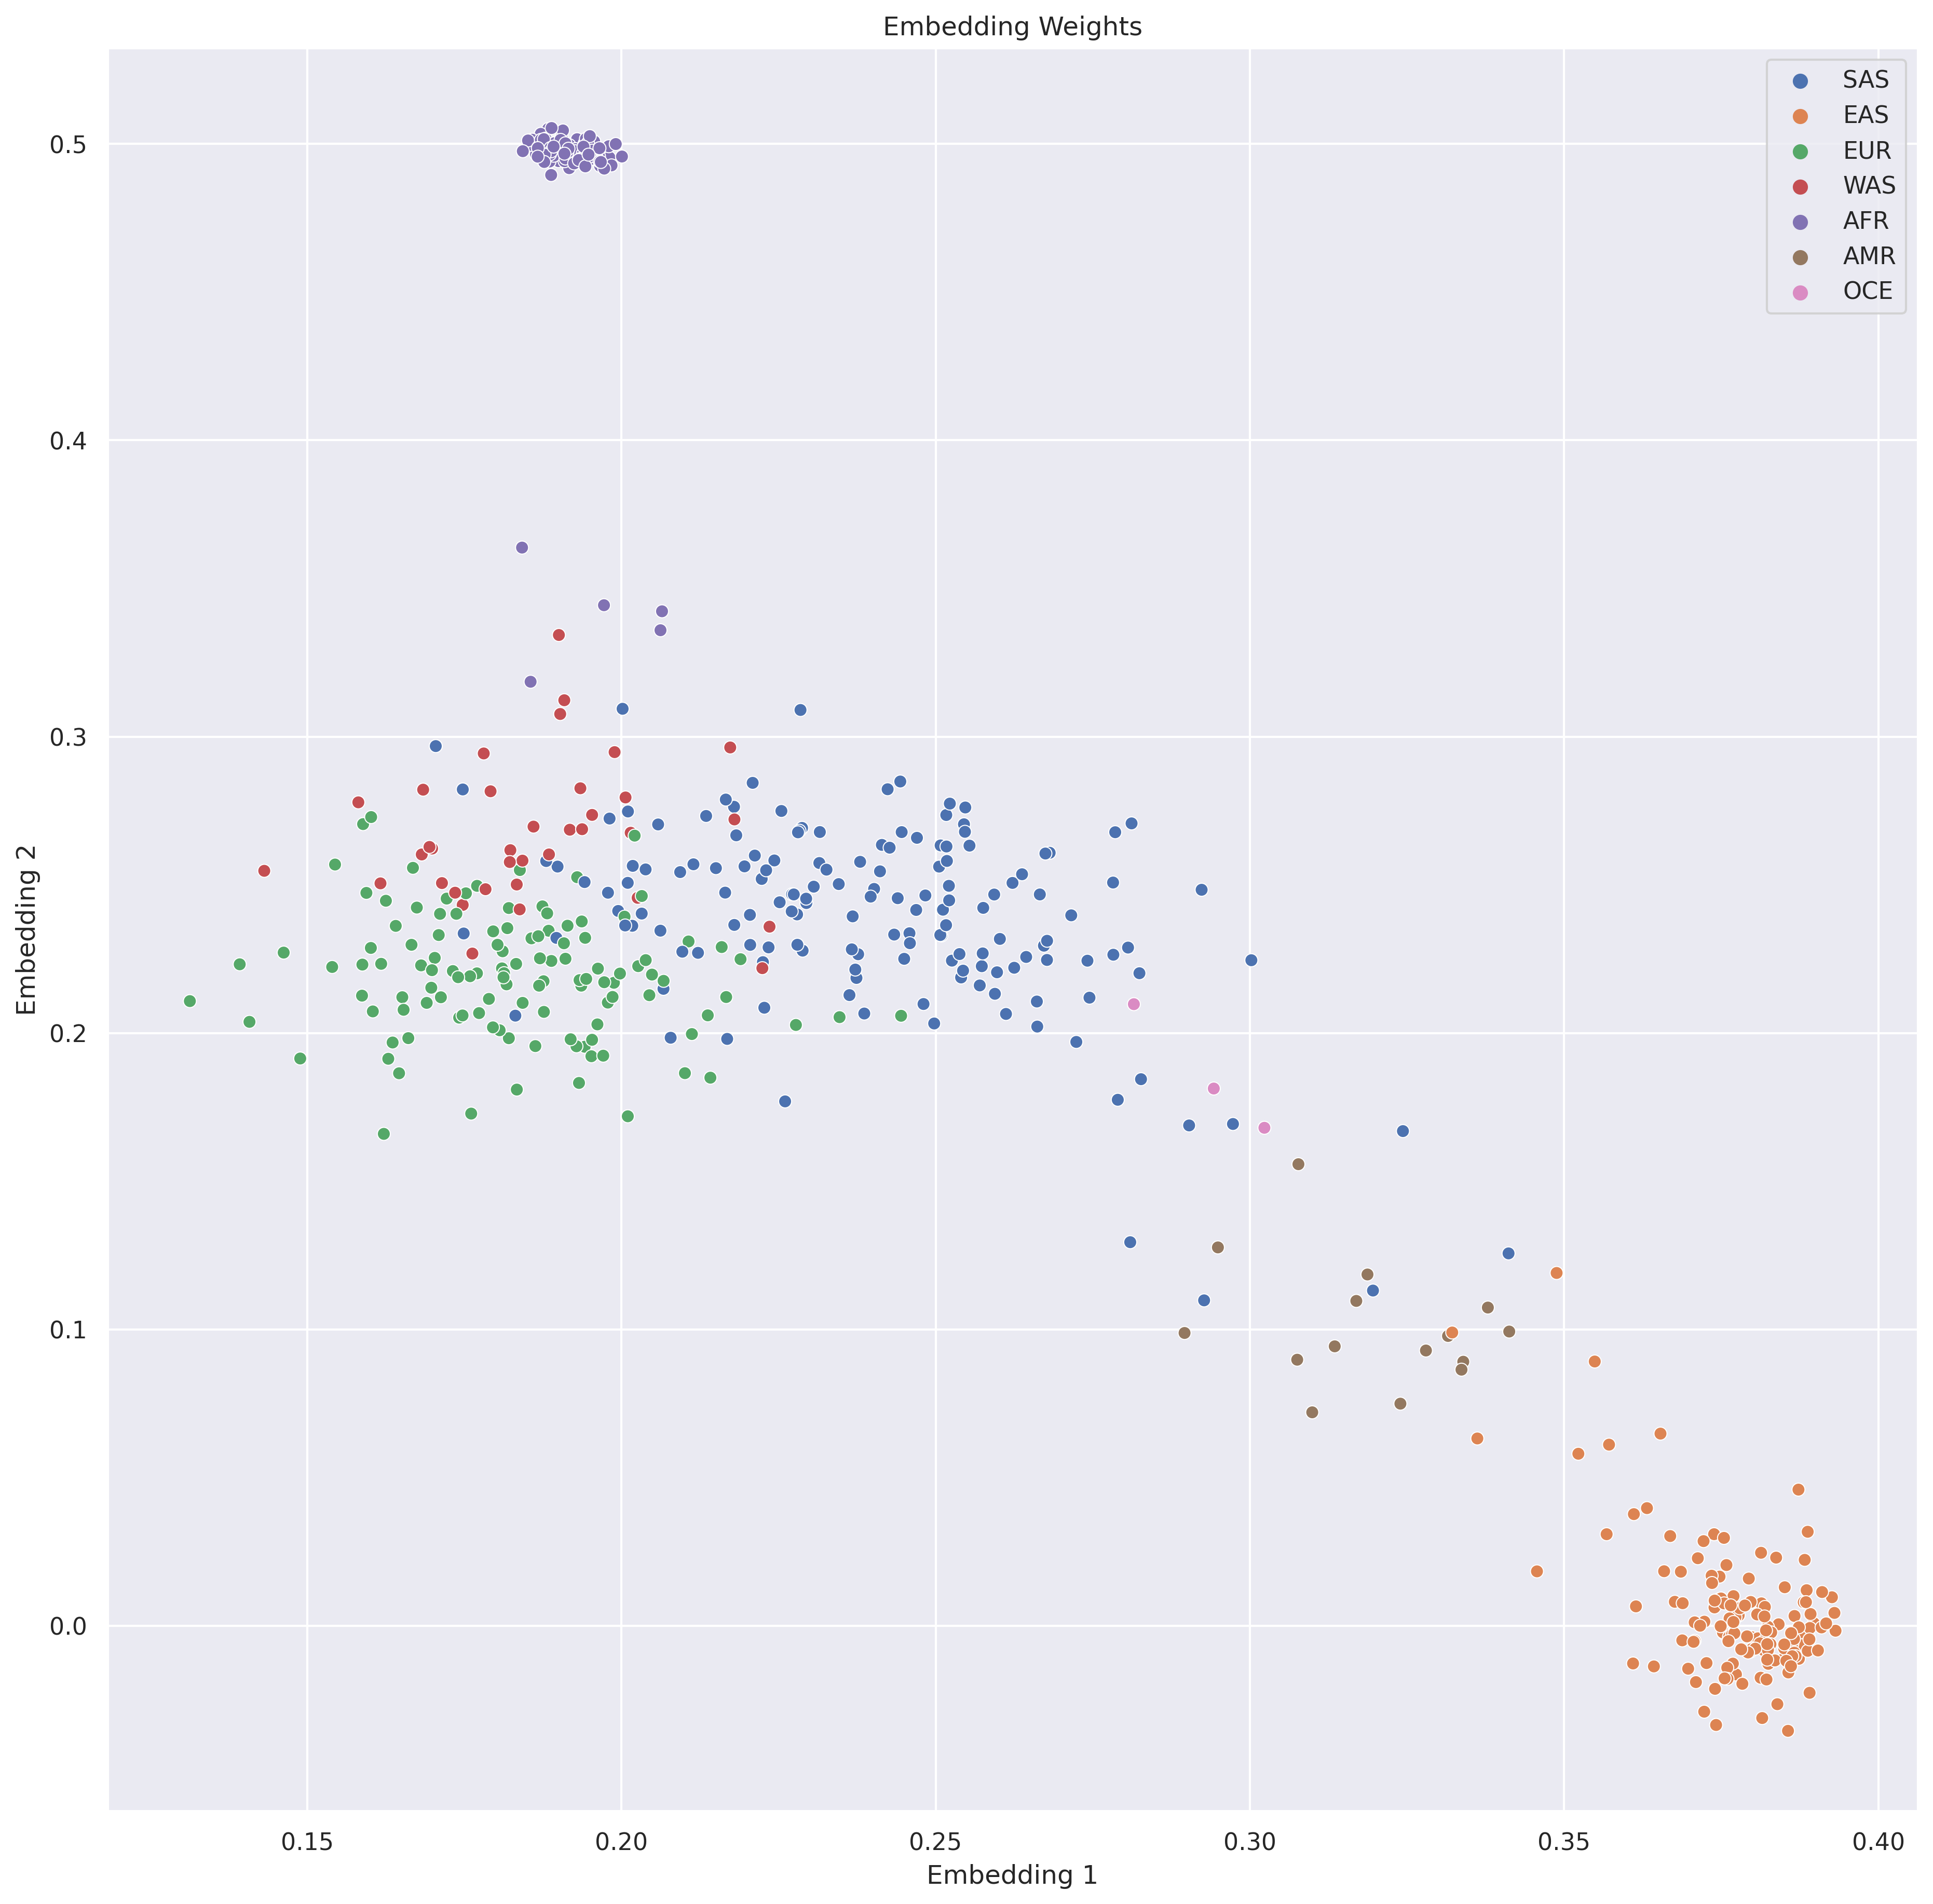

In [30]:
plt.figure(figsize=[15, 15], dpi=300)
sp_full = [dataset.suppop_label_index[x] for x in suppop_labels]
p_full = [dataset.pop_label_index[x] for x in pop_labels]
plot_weights_pca(embeddings, sp_full)
plt.show()

In [ ]:
def decode_tree(model, embeddings, device, fast_decoding):
    """Build a binary tree (nx graph) from leaves' embeddings. Assume points are normalized to same radius."""
    with torch.no_grad():
        leaves_embeddings = model.HypHCLoss.normalize_embeddings(torch.tensor(embeddings).to(device))
        leaves_embeddings = project(leaves_embeddings).cpu()
    sim_fn = lambda x, y: torch.sum(x * y, dim=-1)
    if fast_decoding:
        parents = nn_merge_uf_fast_np(leaves_embeddings, S=sim_fn, partition_ratio=1.2)
    else:
        parents = sl_from_embeddings(leaves_embeddings, sim_fn)
    tree = nx.DiGraph()
    for i, j in enumerate(parents[:-1]):
        tree.add_edge(j, i)
    return tree


In [ ]:
##
embs_pca_two = PCA().fit_transform(embeddings)[:,:2]
pca_tree = decode_tree(model, embs_pca_two, device, True)
with torch.no_grad():
    embs_normed = model.HypHCLoss.normalize_embeddings(torch.tensor(embs_pca_two).to(device))
    leaves_embeddings = project(embs_normed).cpu().numpy()
fig = plt.figure(figsize=(15, 15), dpi=300)
ax = fig.add_subplot(111)
ax = plot_tree_from_leaves(ax, pca_tree, leaves_embeddings * 100, labels=sp_full)
for line in range(len(suppop_labels)):
#     if p_full[line] != "Finnish":
#         continue
    ax.text(leaves_embeddings[line,0] * 100 +0.001, leaves_embeddings[line,1] * 100, 
                 p_full[line], ha='left', 
            color='black', va="baseline", rotation=45, size=8)

plt.show()

###
# test_tree = decode_tree(model, embeddings, device, True)
# with torch.no_grad():
#     embs_normed = model.HypHCLoss.normalize_embeddings(torch.tensor(embeddings).to(device))
#     leaves_embeddings = project(embs_normed).cpu().numpy()
# leaves_pca = PCA().fit_transform(leaves_embeddings)[:,:2]
# fig = plt.figure(figsize=(15, 15), dpi=300)
# ax = fig.add_subplot(111)
# ax = plot_tree_from_leaves(ax, test_tree, leaves_pca * 100, labels=sp_full)
# plt.show()


In [ ]:
plt.plot(sorted(np.mean(np.absolute(snps-recons),axis=1)))
plt.show()

In [19]:
abs_diffs = np.absolute(snps-recons)
print(np.min(abs_diffs), np.mean(abs_diffs), np.max(abs_diffs))

2.4020672e-05 0.46969086 0.9889439


In [20]:
preds = recons > 0.5
abs_preds = np.sum(snps == preds) / len(snps.flatten())
print(abs_preds)

0.6037471939291736


In [ ]:
sample_input = torch.randint(low=0,  high=1, size=(2,1000))

In [ ]:
sample_embedding = torch.rand(10,)

In [ ]:
test_vae.embed(sample_input.float()).shape

In [ ]:
test_total = test_vae(sample_input.float())

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#What is the right way to calculate KL divergence?
#Is doing the expmap the right thing, and what does it do?

In [ ]:
tenstest = torch.tensor([[2,3], [3,2.9]]).float()

In [ ]:
torch.nn.Softmax(dim=-1)(tenstest)

In [ ]:
tenstest2 = torch.tensor([[3,6]]).float()
torch.nn.Softmax(dim=1)(tenstest2)

In [ ]:
np.exp(5) / (np.exp(4) + np.exp(5))

In [ ]:
tz = torch.zeros((3,2))

In [ ]:
tz.unsqueeze(-2).shape

In [ ]:
np.log(2)

In [ ]:
nn.Softplus()(torch.zeros(1, 1))

In [ ]:
dataset[0][0].shape[-1]